# Exploring Household Energy Usage with Time Series Data

The project aims to analyze household electricity consumption patterns with respect to the day of the week and specific time intervals. By examining the temporal distribution of energy usage, the study seeks to identify peak demand periods and underlying trends. The insights gained will support the development of targeted strategies to optimize consumption and promote energy savings. The analysis leverages time series resampling, moving averages, and data visualization techniques applied to the Individual Household Electric Power Consumption dataset.


### Dataset Description

The Individual Household Electric Power Consumption dataset contains the following variables:

1. **Date**: Date in format dd/mm/yyyy.  
2. **Time**: Time in format hh:mm:ss.  
3. **Global_active_power**: Household global minute-averaged active power (in kilowatt).  
4. **Global_reactive_power**: Household global minute-averaged reactive power (in kilowatt).  
5. **Voltage**: Minute-averaged voltage (in volt).  
6. **Global_intensity**: Household global minute-averaged current intensity (in ampere).  
7. **Sub_metering_1**: Energy sub-metering No. 1 (in watt-hour of active energy). Corresponds to the kitchen, containing mainly a dishwasher, an oven, and a microwave (hot plates are gas powered).  
8. **Sub_metering_2**: Energy sub-metering No. 2 (in watt-hour of active energy). Corresponds to the laundry room, containing a washing machine, tumble-drier, refrigerator, and a light.  
9. **Sub_metering_3**: Energy sub-metering No. 3 (in watt-hour of active energy). Corresponds to an electric water-heater and an air-conditioner.




---



**Import dataset**

In [4]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [5]:
chunks = pd.read_csv('D:\PythonProjects\DATASET\household_power_consumption.txt',
                     sep=';',
                     na_values='?',
                     chunksize=100000
                     )

df = pd.concat(chunks)

print(f"Rows, Columns : {df.shape} \n")
print(f"{df.head()} \n")
print(df.info())

Rows, Columns : (2075259, 9) 

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries,

**Data Cleaning**

In [6]:
# % of missing values and duplicates
print(f"Minssing values: {df['Global_active_power'].isna().sum()/df.shape[0]*100:.2f}%")
print(f"Duplicates: {df.duplicated(subset = ['Date','Time']).sum()/df.shape[0]*100:.2f}%")

# Drop missing values
df.dropna(subset=['Global_active_power'], inplace=True)

# Drop duplicates
df = df.drop_duplicates(subset = ['Date','Time'], keep='first') # Removing duplicates

Minssing values: 1.25%
Duplicates: 0.00%


**Date Column Preprocessing**

In [7]:
# Create the date time column

df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
HTML("<div style='overflow-x: auto'>" + df.head().to_html() + "</div>")

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [8]:
# Extract different granularities from DateTime

df['Hour'] = df['DateTime'].dt.hour
df['Month'] = df['DateTime'].dt.month
df['Year'] = df['DateTime'].dt.year
df['Day_of_week'] = df['DateTime'].dt.day_name()

# Assign the hour to a time slot
def assign_time_slot(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['Time_Slot'] = df['Hour'].apply(assign_time_slot)

# Assign the month to a season
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(assign_season)

**Average consumption by time categories**

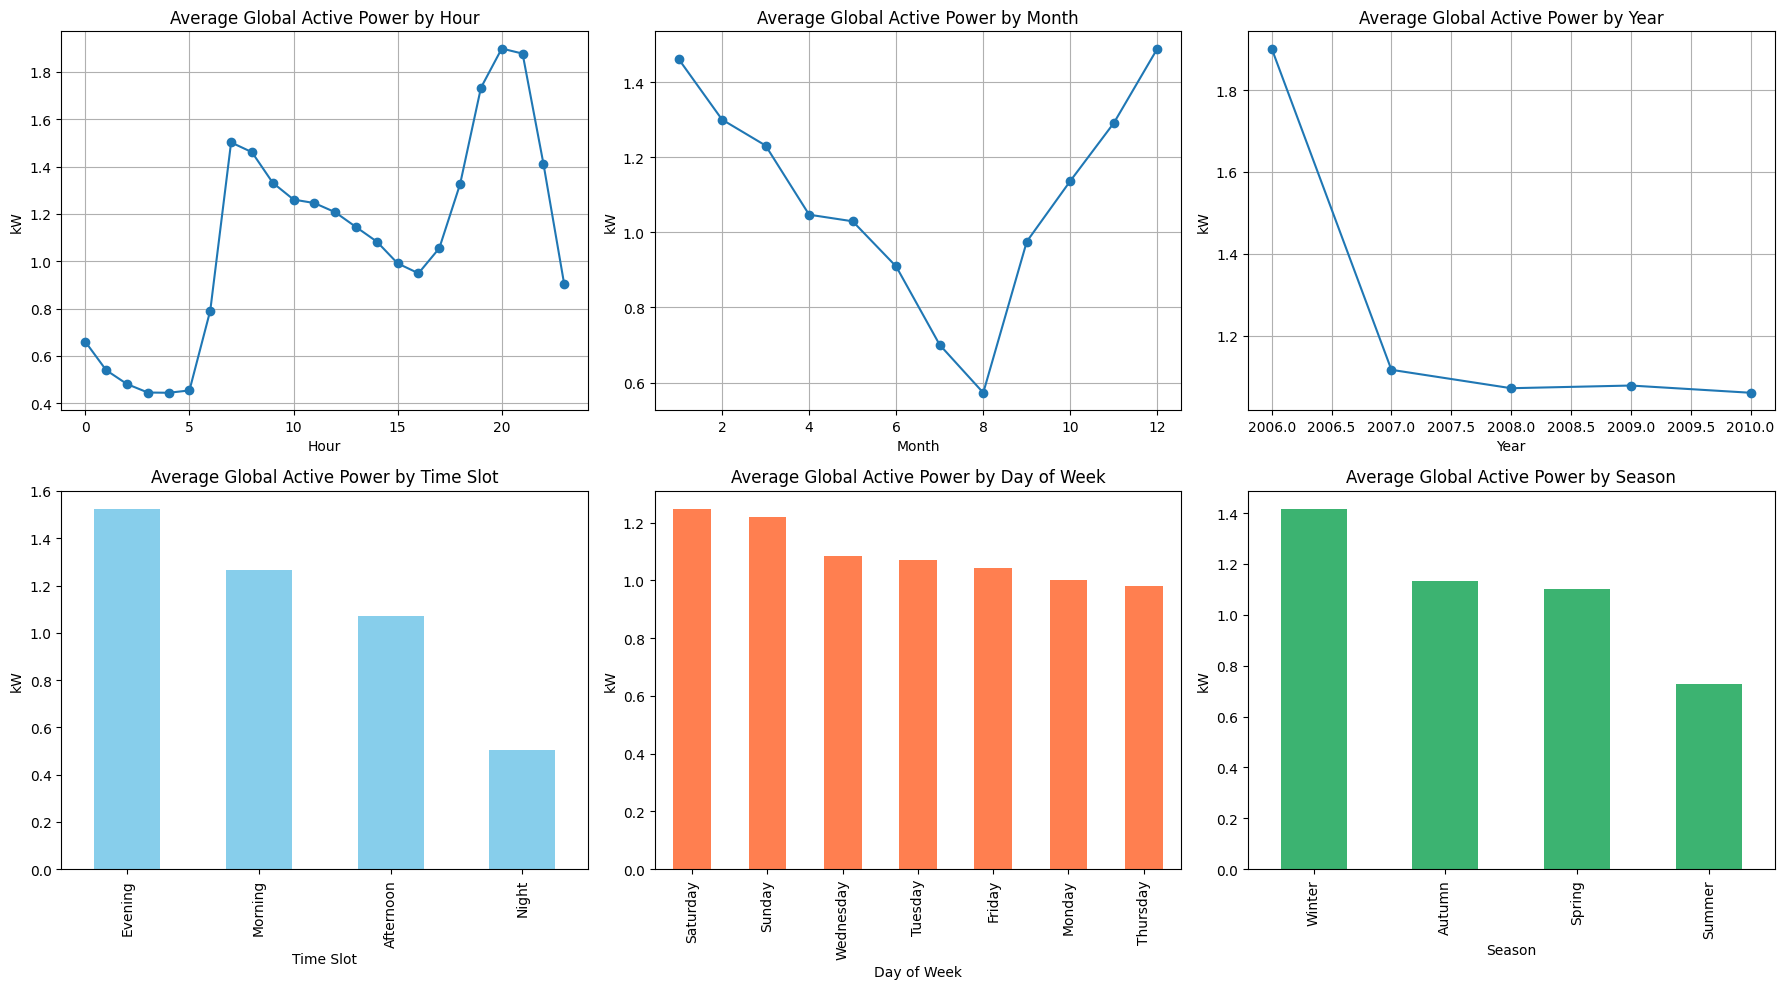

In [ ]:
# By hour
avg_hour = df.groupby('Hour')['Global_active_power'].mean()

# By time slot
avg_time_slot = df.groupby('Time_Slot')['Global_active_power'].mean().sort_values(ascending=False)

# By day of the week
avg_day = df.groupby('Day_of_week')['Global_active_power'].mean().sort_values(ascending=False)

# By month
avg_month = df.groupby('Month')['Global_active_power'].mean()

# By season
avg_season = df.groupby('Season')['Global_active_power'].mean().sort_values(ascending=False)

# By year
avg_year = df.groupby('Year')['Global_active_power'].mean()

# Plot the result

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Line plots
avg_hour.plot(kind='line', marker='o', ax=axs[0, 0], grid=True)
axs[0, 0].set_title('Average Global Active Power by Hour')
axs[0, 0].set_xlabel('Hour')
axs[0, 0].set_ylabel('kW')

avg_month.plot(kind='line', marker='o', ax=axs[0, 1], grid=True)
axs[0, 1].set_title('Average Global Active Power by Month')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('kW')

avg_year.plot(kind='line', marker='o', ax=axs[0, 2], grid=True)
axs[0, 2].set_title('Average Global Active Power by Year')
axs[0, 2].set_xlabel('Year')
axs[0, 2].set_ylabel('kW')

# Bar plots
avg_time_slot.plot(kind='bar', color='skyblue', ax=axs[1, 0],)
axs[1, 0].set_title('Average Global Active Power by Time Slot')
axs[1, 0].set_xlabel('Time Slot')
axs[1, 0].set_ylabel('kW')

avg_day.plot(kind='bar', color='coral', ax=axs[1, 1])
axs[1, 1].set_title('Average Global Active Power by Day of Week')
axs[1, 1].set_xlabel('Day of Week')
axs[1, 1].set_ylabel('kW')

avg_season.plot(kind='bar', color='mediumseagreen', ax=axs[1, 2])
axs[1, 2].set_title('Average Global Active Power by Season')
axs[1, 2].set_xlabel('Season')
axs[1, 2].set_ylabel('kW')

plt.tight_layout()
plt.show()

**Key observations:**

- As expected, energy consumption peaks in the evening hours, likely when family members gather at home after work or school, and drops during sleeping hours at night.

- The highest consumption occurs on weekends, when the family is probably at home due to work and school inactivity.

- Demand is highest during the winter months, likely due to increased heating needs, and lowest in the summer for the opposite reason.

- Yearly consumption is relatively stable (the initial drop is due to the series starting in December).

**More detail:**

- Consumption remains low during the night, spikes between 6 and 7 a.m., levels off until around 4 p.m., and then rises again in the evening.
- The most energy-intensive months are January and December, while August shows the lowest consumption, likely driven by seasonal heating patterns.
- Over the entire dataset, yearly consumption appears fairly stable on average (the initial peak in 2006 is due to starting the series in December).

**Average Consumption (cross-dimension analysis)**

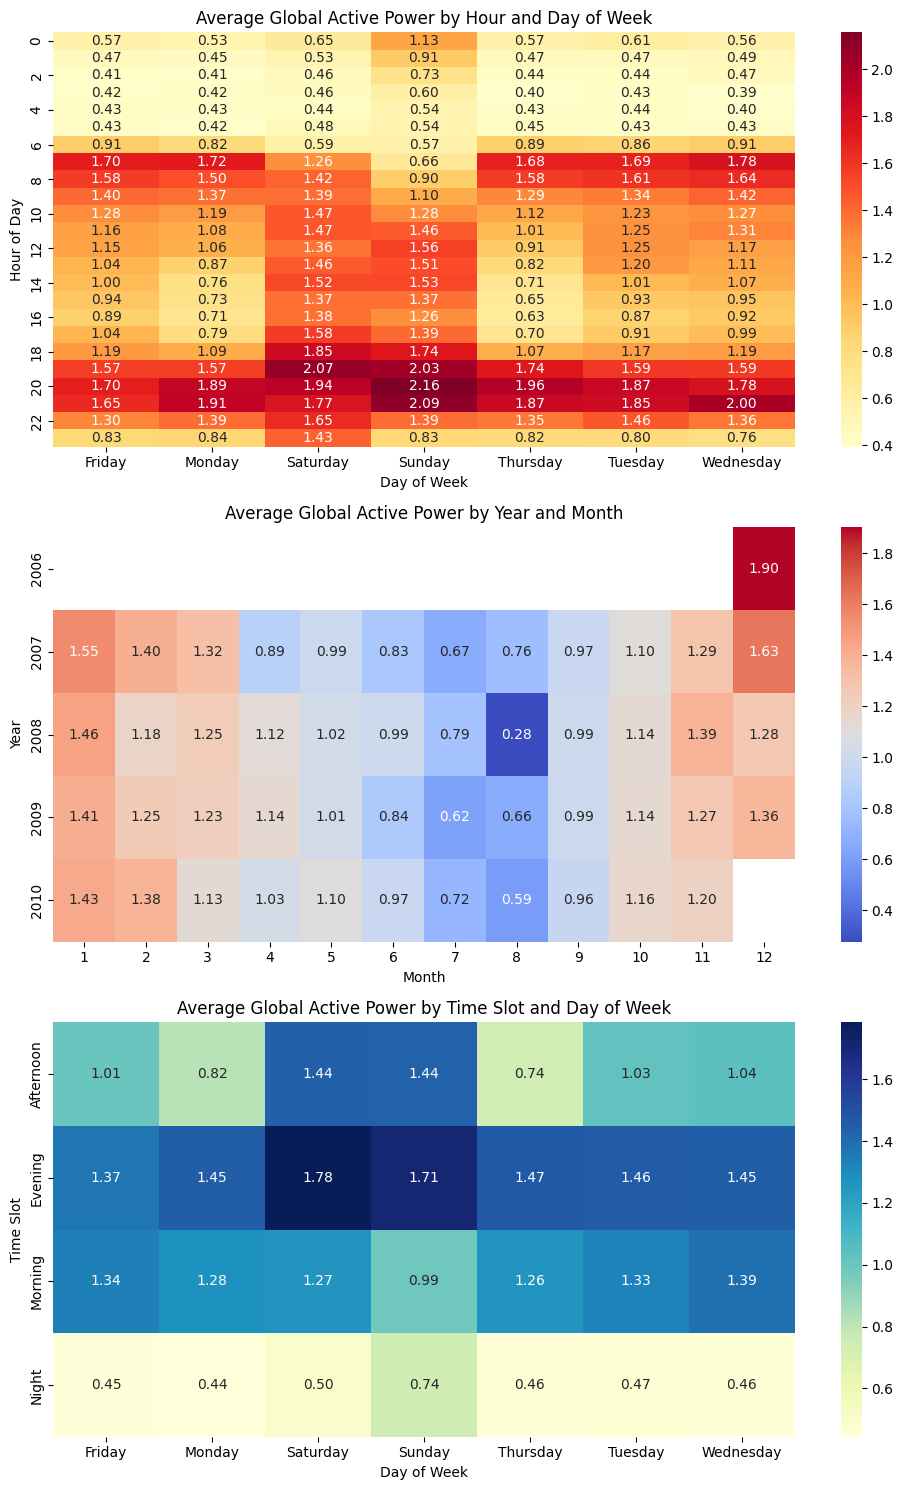

In [ ]:
# By hour and day
pivot_hour_day = df.pivot_table(
    values='Global_active_power',
    index='Hour',
    columns='Day_of_week',
    aggfunc='mean'
)

# By time slot and day
pivot_slot_day = df.pivot_table(
    values='Global_active_power',
    index='Time_Slot',
    columns='Day_of_week',
    aggfunc='mean'
)

# By year and month
pivot_year_month = df.pivot_table(
    values='Global_active_power',
    index='Year',
    columns='Month',
    aggfunc='mean'
)

# Plot

plt.figure(figsize=(10,15))

# Hour/Day
plt.subplot(3, 1, 1)
sns.heatmap(pivot_hour_day, cmap='YlOrRd', annot=True, fmt=".2f")
plt.title('Average Global Active Power by Hour and Day of Week')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')

# Year/Month
plt.subplot(3, 1, 2)
sns.heatmap(pivot_year_month, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average Global Active Power by Year and Month')
plt.ylabel('Year')
plt.xlabel('Month')

# Time slot/Day
plt.subplot(3, 1, 3)
sns.heatmap(pivot_slot_day, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Average Global Active Power by Time Slot and Day of Week')
plt.ylabel('Time Slot')
plt.xlabel('Day of Week')

plt.tight_layout()
plt.show()

**Key observations:**

*   The highest energy consumption occurred on Saturdays and Sundays during the evening hours between 19:00 and 21:00.
*   In terms of monthly consumption, the peak was in December 2006, while the lowest point was in August 2008.

## Time Series Model

**Average consumption by frequency**

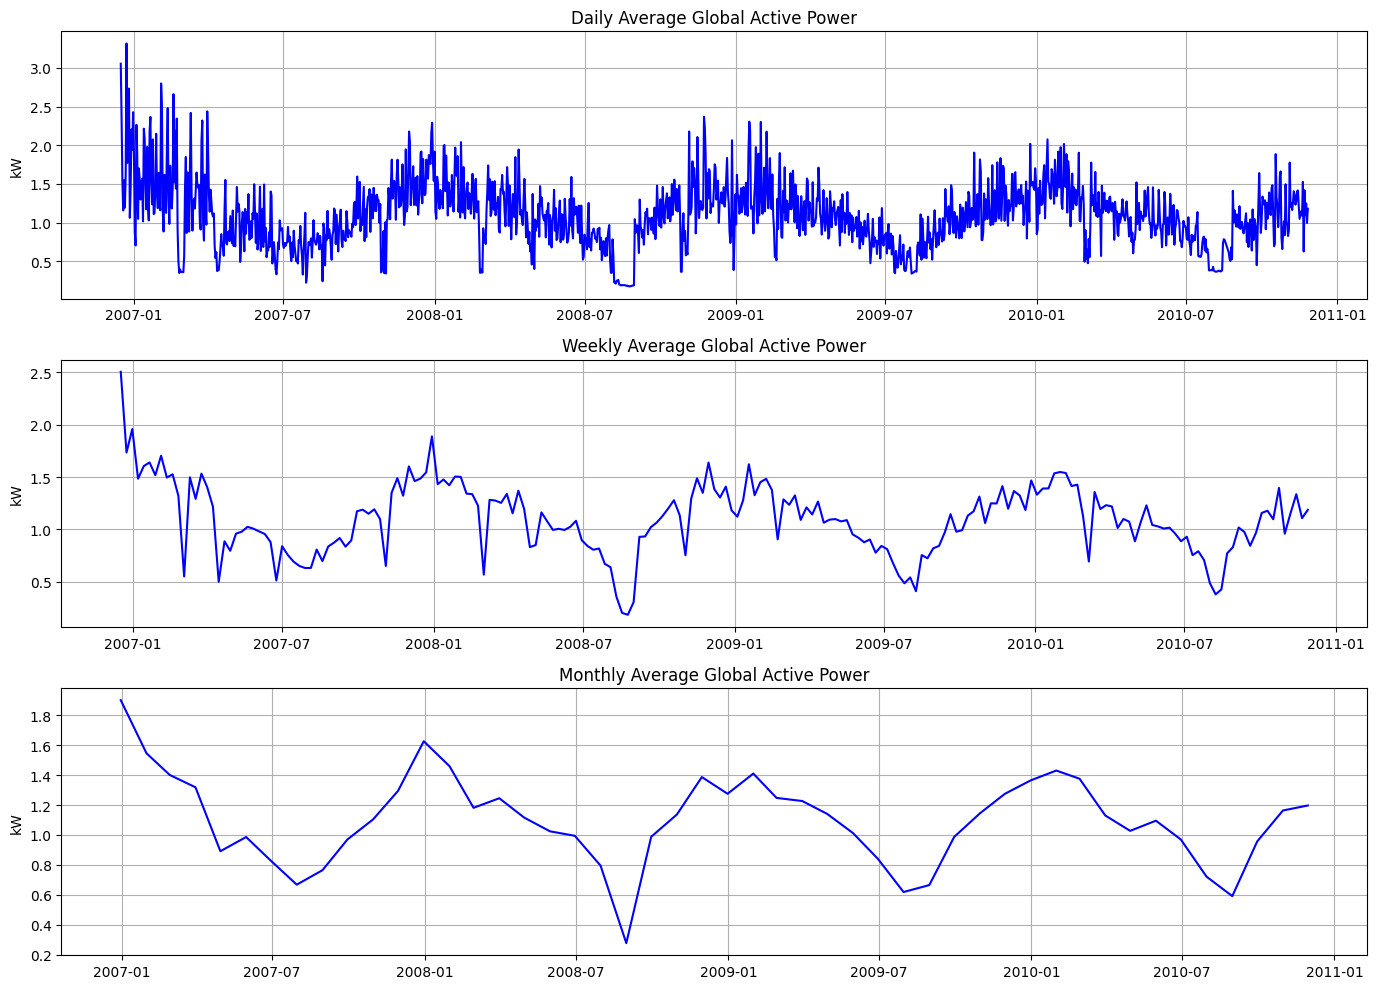

In [ ]:
# Daily series: average consumption per day ('D')
df_daily = df.resample('D', on='DateTime').mean(numeric_only=True)
df_daily.dropna(subset=['Global_active_power'], inplace=True)

# Weekly series: average consumption per week ('W')
df_weekly = df.resample('W', on='DateTime').mean(numeric_only=True, )
df_weekly.dropna(subset=['Global_active_power'], inplace = True)

# Monthly series: average consumption per month ('ME')
df_monthly = df.resample('ME', on='DateTime').mean(numeric_only=True)
df_monthly.dropna(subset=['Global_active_power'], inplace = True)


# Plot

plt.figure(figsize=(14, 10))

# Daily
plt.subplot(3, 1, 1)
plt.plot(df_daily['Global_active_power'], label='Daily Avg', color='blue')
plt.title('Daily Average Global Active Power')
plt.ylabel('kW')
plt.grid(True)

# Weekly
plt.subplot(3, 1, 2)
plt.plot(df_weekly['Global_active_power'], label='Weekly Avg', color='blue')
plt.title('Weekly Average Global Active Power')
plt.ylabel('kW')
plt.grid(True)


# Monthly
plt.subplot(3, 1, 3)
plt.plot(df_monthly['Global_active_power'], label='monthly Avg', color='blue')
plt.title('Monthly Average Global Active Power')
plt.ylabel('kW')
plt.grid(True)

plt.tight_layout()
plt.show()


**Key observations:**



*   Energy consumption appears overall steady across all time scales considered, suggesting regular household power usage.
*   The series displays clear yearly seasonality.
*   As expected, shorter time scales show higher variability.
*   All granularities exhibit a consistent seasonality amplitude (additive model).

**Time series decomposition**

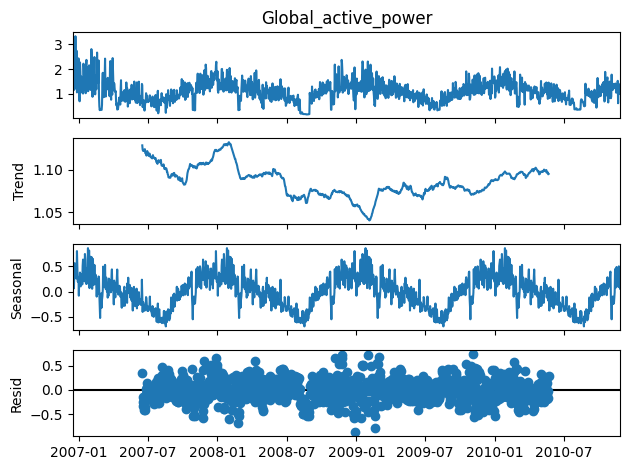

In [ ]:
daily_power = df_daily['Global_active_power']

# Decompose the daily series into the core components: Trend, Seasonality, Resid
decomposition = seasonal_decompose(x = daily_power, model='additive', period= 365)

# Plot
decomposition.plot()
plt.show()

**Understanding the result:**

*   The trend suggests the presence of stationarity: no evident long-term upward or downward movement emerges in the average daily consumption.
*   The seasonal component displays a clear yearly repeating pattern.
*   The residual component is randomly distributed around 0 and does not exhibit any obvious pattern, suggesting that the trend and seasonal components explain daily consumption well.



**Stationarity Check**

The stationarity is the main assumption in the ARIMA and SARIMA models that will be applied later.

In [ ]:
# ADF test to check the non-stationarity hypothesis
result = adfuller(daily_power)
if result[1] < 0.05:
  print("p-value < 0.05 => We reject null hypothesis with a 5% significance level")
else:
  print("p-value > 0.05 => We fail to reject the null hypothesis with a 5% significance level")

p-value < 0.05 => We reject null hypothesis with a 5% significance level


**Key observations:**


*   Based on the result, the series is likely stationary.

**Autocorrelation analysis**

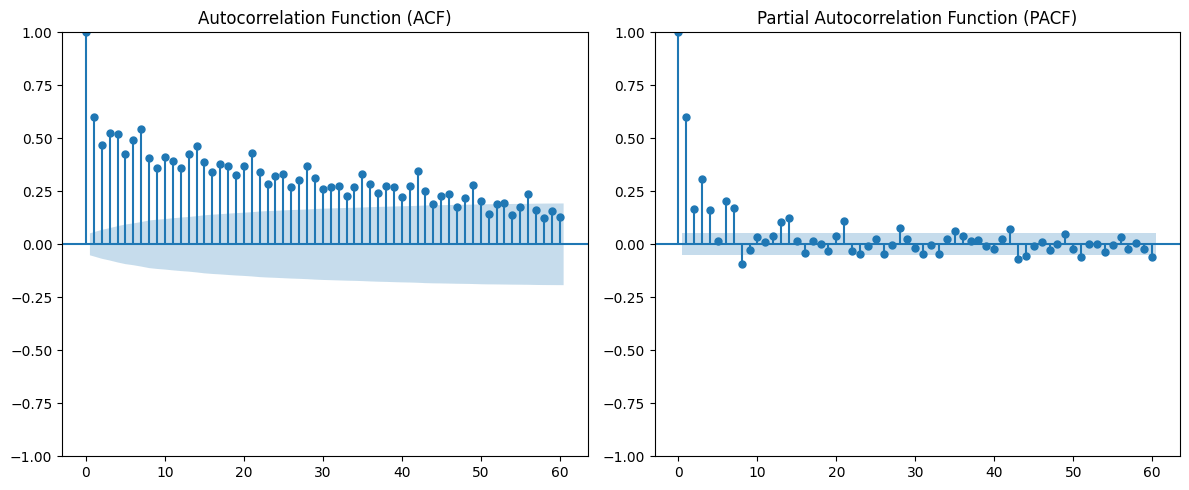

In [ ]:
#Plot

plt.figure(figsize=(12,5))

# Autocorrelation (ACF)
plt.subplot(1,2,1)
plot_acf(daily_power, lags=60, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Partial autocorrelation (PACF)
plt.subplot(1,2,2)
plot_pacf(daily_power, lags=60, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Key insights:

*   The ACF shows that today’s power consumption strongly depends on previous observations, with decreasing strength as the lag increases.
*   The ACF decays slowly and remains significant for more than 40 lags, suggesting that the random component may still affect today’s consumption (despite the previously observed stationarity).
*   The PACF highlights the first 7 lags as having the greatest impact on current power usage, while the remaining lags tend to be insignificant..
* Correlation spikes occur at multiples of 7, confirming the weekly seasonality observed in the initial exploratory analysis.


**Split dataset into train and test**



In [ ]:
# Train size
train_size = int(df_daily.shape[0]*0.8)

# Train and Test subset
train = df_daily.iloc[:train_size].copy()
test = df_daily.iloc[train_size:].copy()

**ARMA prediction & analysis**
*   The autoregressive order (p) was set to 7 to account for lags corresponding to the weekly seasonality.
*   The differencing order (d) was set to 0, as there is sufficient evidence to assume stationarity. Additionally, the model returns higher AIC/BIC values when first-order differencing (d = 1) is applied.







/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                 1146
Model:                  ARIMA(7, 0, 1)   Log Likelihood                -274.799
Date:                 Wed, 18 Jun 2025   AIC                            569.597
Time:                         15:57:20   BIC                            620.038
Sample:                              0   HQIC                           588.641
                                - 1146                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1428      0.083     13.786      0.000       0.980       1.305
ar.L1          0.0947      0.106      0.896      0.370      -0.112       0.302
ar.L2          0.0900      0.050      1.789 

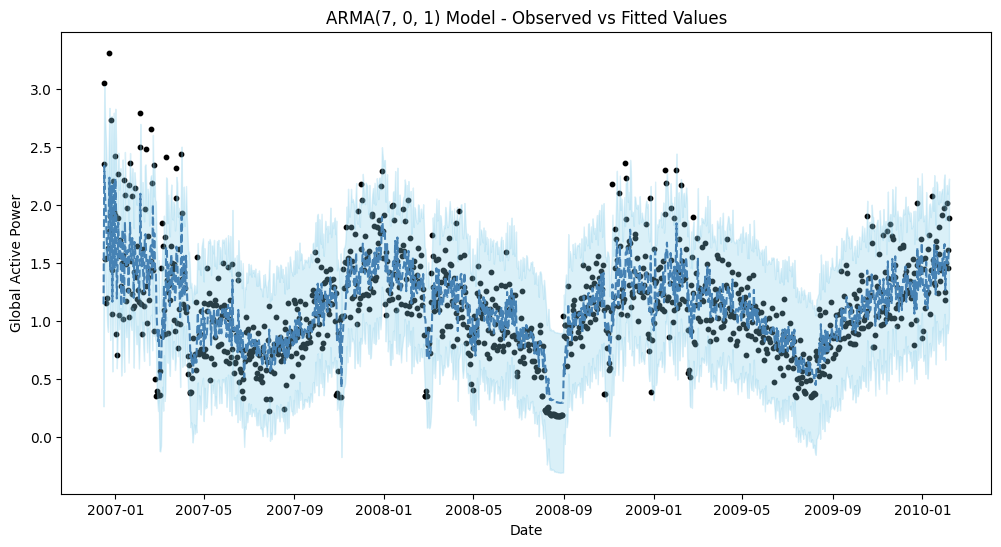

In [ ]:
daily_power = train['Global_active_power']

# Define the order parameters AR (p), I (d), MA (q)

p = 7
d = 0
q = 1

# ARMA model

model_ARIMA = ARIMA(
    daily_power,
    order = (p, d, q)
    )

# Fit (in-sample predictions)

results_ARIMA = model_ARIMA.fit()

# Print the summary
print(results_ARIMA.summary())

# Fitted values
fitted_values = results_ARIMA.fittedvalues

# Confidence intervals
pred = results_ARIMA.get_prediction(start=train.index[0], end=train.index[-1])
pred_mean_a = pred.predicted_mean
conf_int = pred.conf_int(0.05)

# Plot observed vs fitted values
plt.figure(figsize=(12,6))
plt.scatter(train.index, daily_power, color='black', s=10, label='Observed')
plt.plot(train.index, fitted_values, color='steelblue', linestyle='--', label='Fitted')
plt.fill_between(
    train.index,
    conf_int.iloc[:, 0],  # lower bound
    conf_int.iloc[:, 1],  # upper bound
    color='skyblue',
    alpha=0.3,
    label='Uncertainty Interval'
)
plt.title('ARMA(7, 0, 1) Model - Observed vs Fitted Values')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
#plt.legend()
plt.show()

**SARIMA prediction & analsysis**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:               Global_active_power   No. Observations:                 1146
Model:             SARIMAX(6, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -246.585
Date:                           Wed, 18 Jun 2025   AIC                            513.169
Time:                                   15:57:25   BIC                            563.610
Sample:                                        0   HQIC                           532.213
                                          - 1146                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4949      0.197      2.510      0.012       0.108       0.881
ar.L2         -0.0107      0.077     -0.138

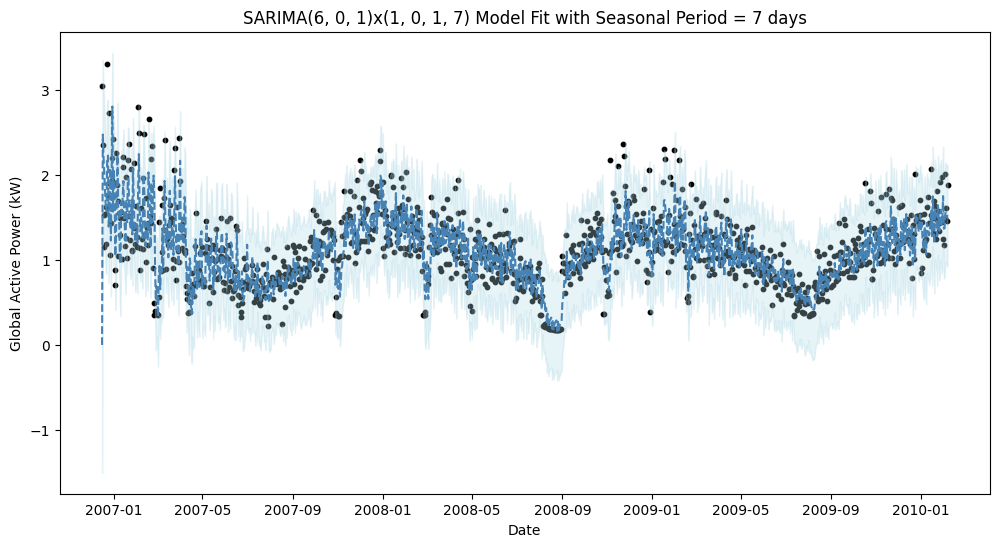

In [ ]:
# Defined the parameters (P, D, Q, S refer to the seasonality component)

p = 6
P = 1
D = 0
Q = 1
S = 7

# SARIMA model with weekly seasonality (S)
model_SARIMA = SARIMAX(
    daily_power,
    order=(p, d, q),
    seasonal_order= (P, D, Q, S)
    )

# Fit (in-sample predictions)
results_SARIMA = model_SARIMA.fit()

# Print the result
print(results_SARIMA.summary())

# Fitted values
fitted_values = results_SARIMA.fittedvalues

# Confidence intervals
pred = results_SARIMA.get_prediction(start = train.index[0], end = train.index[-1])
pred_mean_s = pred.predicted_mean
conf_int = pred.conf_int(0.05)

# Plot observed vs fitted values

plt.figure(figsize=(12,6))
plt.scatter(train.index, daily_power, color='black', s=10, label='Observed')
plt.plot(train.index, fitted_values, color='steelblue', linestyle='--', label='Fitted')
plt.fill_between(
    train.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='lightblue',
    alpha=0.3,
    label='Uncertainty Interval'
)
plt.title('SARIMA(6, 0, 1)x(1, 0, 1, 7) Model Fit with Seasonal Period = 7 days')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
#plt.legend()
plt.show()

**Understanding the results:**

*   The predictions seem quite accurate, though somewhat conservative with respect to extreme consumption values. Additionally, most observed values fall within the uncertainty intervals.
*   The first lag is significant only in the SARIMA model.
*   Lags L3, L4, and L6 are significant in both models.
*   Both models (ARIMA and SARIMA) show evidence of autocorrelation, heteroskedasticity, and non-normal distribution of residuals.

**ARIMA & SARIMA Diagnostic**

--- Diagnostic check for SARIMA ---


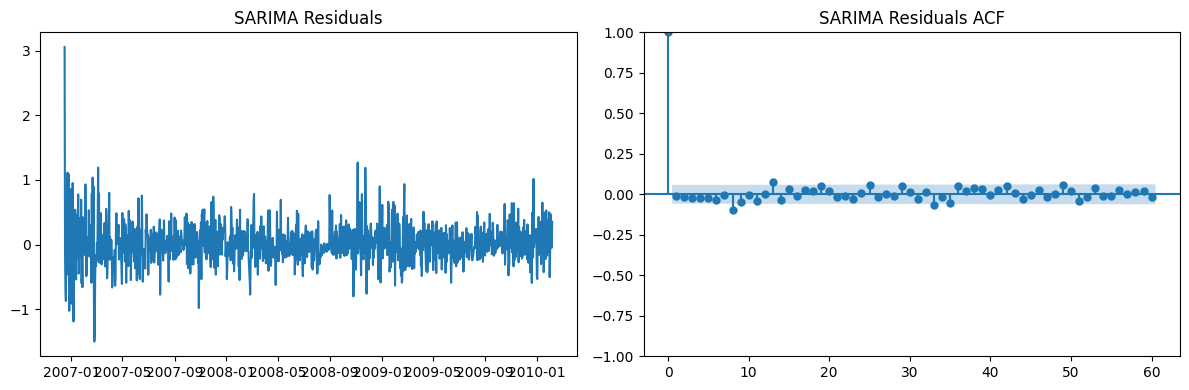

--- Diagnostic check for ARIMA ---


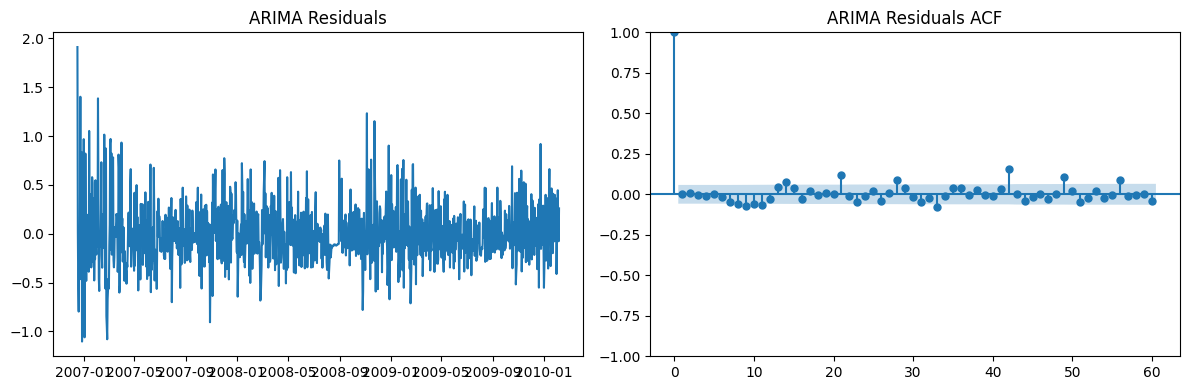

In [ ]:
# Function to extract and plot the residuals and the autocorrelation (ACF)

def diagnostic_check(result, model_name):
    residuals = result.resid

    print(f"--- Diagnostic check for {model_name} ---")

    # Plot residuals
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(residuals)
    plt.title(f"{model_name} Residuals")

    # Plot residuals ACF
    plt.subplot(1,2,2)
    plot_acf(residuals, lags = 60, ax=plt.gca())
    plt.title(f"{model_name} Residuals ACF")
    plt.tight_layout()
    plt.show()

# Apply to ARIMA and SARIMA
diagnostic_check(results_SARIMA, "SARIMA")
diagnostic_check(results_ARIMA, "ARIMA")


**Understanding the result:**

*   The residuals are randomly distributed around 0, and most correlations are low and non-significant (with only a few exceptions), suggesting that the models capture well the patterns in the data.

**Prophet**

The Prophet model allows to take into considerations multiple seasonality levels simulataneously.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2jlzfx/d22dcn1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpec2jlzfx/_fx2zajc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24763', 'data', 'file=/tmp/tmpec2jlzfx/d22dcn1y.json', 'init=/tmp/tmpec2jlzfx/_fx2zajc.json', 'output', 'file=/tmp/tmpec2jlzfx/prophet_modelmdil2y31/prophet_model-20250618155727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:57:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:57:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


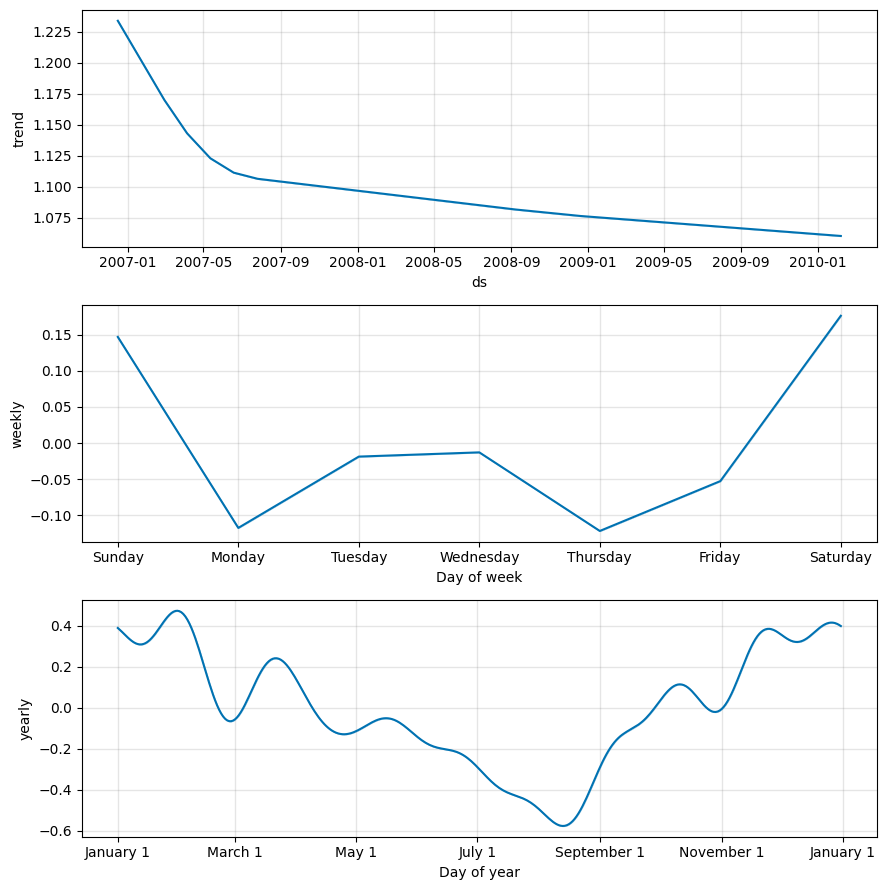

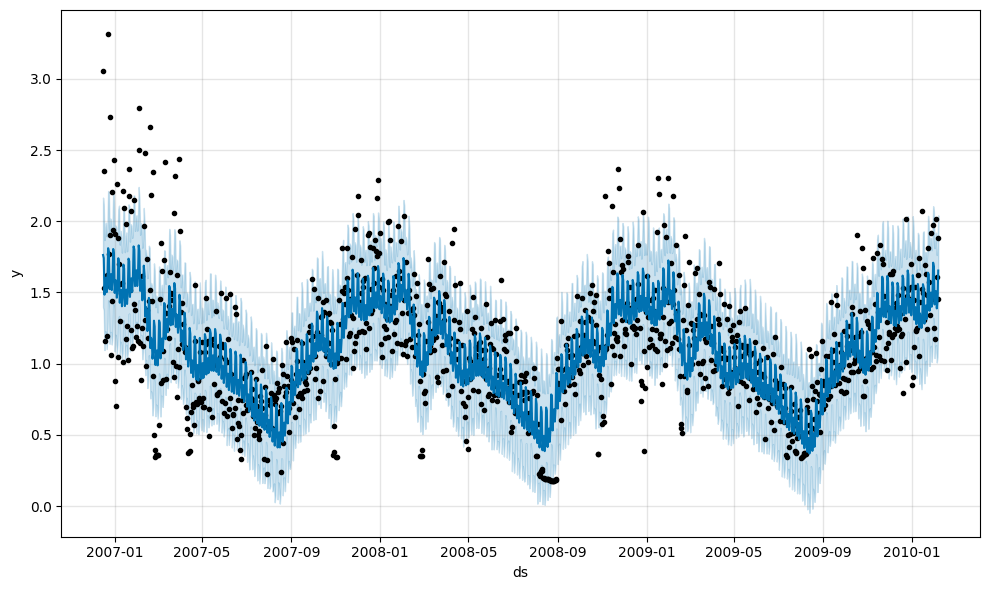

In [ ]:
# Reshape the train set for the Prophet model
train_prophet = train.reset_index()[['DateTime', 'Global_active_power']]
train_prophet.columns = ['ds', 'y']

# Prophet model
model_PROPHET = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
results_PROPHET = model_PROPHET.fit(train_prophet)

# Fitted values
pred_prophet = model_PROPHET.predict(train_prophet)

# Plot observed vs fitted values
fig = model_PROPHET.plot_components(pred_prophet)
fig2 = model_PROPHET.plot(pred_prophet)


**Key observations:**

*   Compared to the previous models, a larger number of observed values fall outside the uncertainty intervals, suggesting that variability is likely being underestimated.

**Prophet Diagnostic**

--- Diagnostic check for Prophet ---


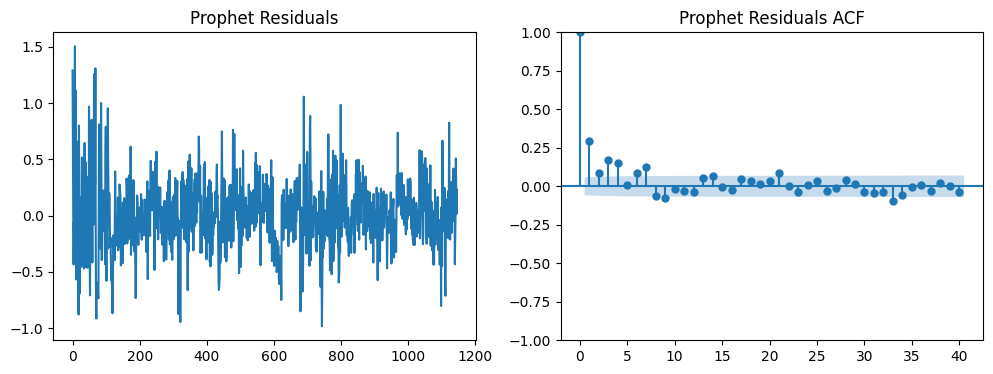

Ljung-Box test (lag 10) p-value: 2.4442497396363065e-38
Jarque-Bera test p-value: 1.917965536541657e-40
Heteroskedasticity test p-value: 2.6640428484671803e-33


In [ ]:
# Function to extract and plot the residuals and the autocorrelation (ACF)

def diagnostic_check_prophet(model, df, model_name):
    # Predict on training data
    forecast = model.predict(df)

    # Residuals
    residuals = df['y'] - forecast['yhat']

    print(f"--- Diagnostic check for {model_name} ---")
    residuals = residuals.dropna()

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(residuals)
    plt.title(f"{model_name} Residuals")

    plt.subplot(1,2,2)
    plot_acf(residuals, ax=plt.gca(), lags=40)
    plt.title(f"{model_name} Residuals ACF")
    plt.show()

    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    jb_test = jarque_bera(residuals)
    het_test = het_arch(residuals, nlags=10)
    print(f"Ljung-Box test (lag 10) p-value: {lb_test['lb_pvalue'].values[0]}")
    print(f"Jarque-Bera test p-value: {jb_test[1]}")
    print(f"Heteroskedasticity test p-value: {het_test[1]}")

# Apply to Prophet
diagnostic_check_prophet(model_PROPHET, train_prophet, "Prophet")

**Key observations:**



*   The residuals are randomly distributed around 0.
*   Correlation remains high and significant among the most recent lags, indicating that Prophet provides a poorer representation of the underlying data.

**Forecasting and Model Evaluation**

In [ ]:
# Actual values
y_true = test['Global_active_power'].values

# Days to predict (ARIMA, SARIMA)
test_steps = test.shape[0]

# Reshape the test set for the Prophet model
test_prophet = test.reset_index()[['DateTime', 'Global_active_power']]
test_prophet.columns = ['ds', 'y']
future_dates = test_prophet[['ds']]


# ARIMA forecast
forecast_arima = results_ARIMA.get_forecast(steps=test_steps)
pred_arima = forecast_arima.predicted_mean #

# SARIMA forecast
forecast_sarima = results_SARIMA.get_forecast(steps=test_steps)
pred_sarima = forecast_sarima.predicted_mean

# Prophet forecast
forecast_prophet = model_PROPHET.predict(future_dates)
forecast_prophet_series = forecast_prophet['yhat'].values

# Function to calculate MAE, RMSE, MAPE
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    return mae, rmse, mape

# Apply to test and train subsets

# Test
mae_arima, rmse_arima, mape_arima = calculate_metrics(y_true, pred_arima)
mae_sarima, rmse_sarima, mape_sarima = calculate_metrics(y_true, pred_sarima)
mae_prophet, rmse_prophet, mape_prophet = calculate_metrics(y_true, forecast_prophet_series)

#Train
y_true_tr = train['Global_active_power']
mae_arima_tr, rmse_arima_tr, mape_arima_tr = calculate_metrics(y_true_tr, pred_mean_a)
mae_sarima_tr, rmse_sarima_tr, mape_sarima_tr = calculate_metrics(y_true_tr, pred_mean_s)
mae_prophet_tr, rmse_prophet_tr, mape_prophet_tr = calculate_metrics(y_true_tr, pred_prophet['yhat'].values)


# Print results
print("Train:")
print(f"ARIMA   - MAE: {mae_arima_tr:.3f}, RMSE: {rmse_arima_tr:.3f}, MAPE: {mape_arima_tr:.2f}%")
print(f"SARIMA  - MAE: {mae_sarima_tr:.3f}, RMSE: {rmse_sarima_tr:.3f}, MAPE: {mape_sarima_tr:.2f}%")
print(f"Prophet - MAE: {mae_prophet_tr:.3f}, RMSE: {rmse_prophet:.3f}, MAPE: {mape_prophet_tr:.2f}% \n")

print("Test:")
print(f"ARIMA   - MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, MAPE: {mape_arima:.2f}%")
print(f"SARIMA  - MAE: {mae_sarima:.3f}, RMSE: {rmse_sarima:.3f}, MAPE: {mape_sarima:.2f}%")
print(f"Prophet - MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}, MAPE: {mape_prophet:.2f}%")

Train:
ARIMA   - MAE: 0.230, RMSE: 0.310, MAPE: 25.21%
SARIMA  - MAE: 0.223, RMSE: 0.314, MAPE: 23.64%
Prophet - MAE: 0.228, RMSE: 0.259, MAPE: 27.89% 

Test:
ARIMA   - MAE: 0.271, RMSE: 0.347, MAPE: 39.03%
SARIMA  - MAE: 0.278, RMSE: 0.350, MAPE: 37.74%
Prophet - MAE: 0.193, RMSE: 0.259, MAPE: 21.23%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


**Key observations:**

*   The three models yield similar error metrics on the training set.
*   Prophet delivers the most accurate out-of-sample predictions.
*   SARIMA and ARMA performed much worse on the test data.

**Visual Comparison Assessment**

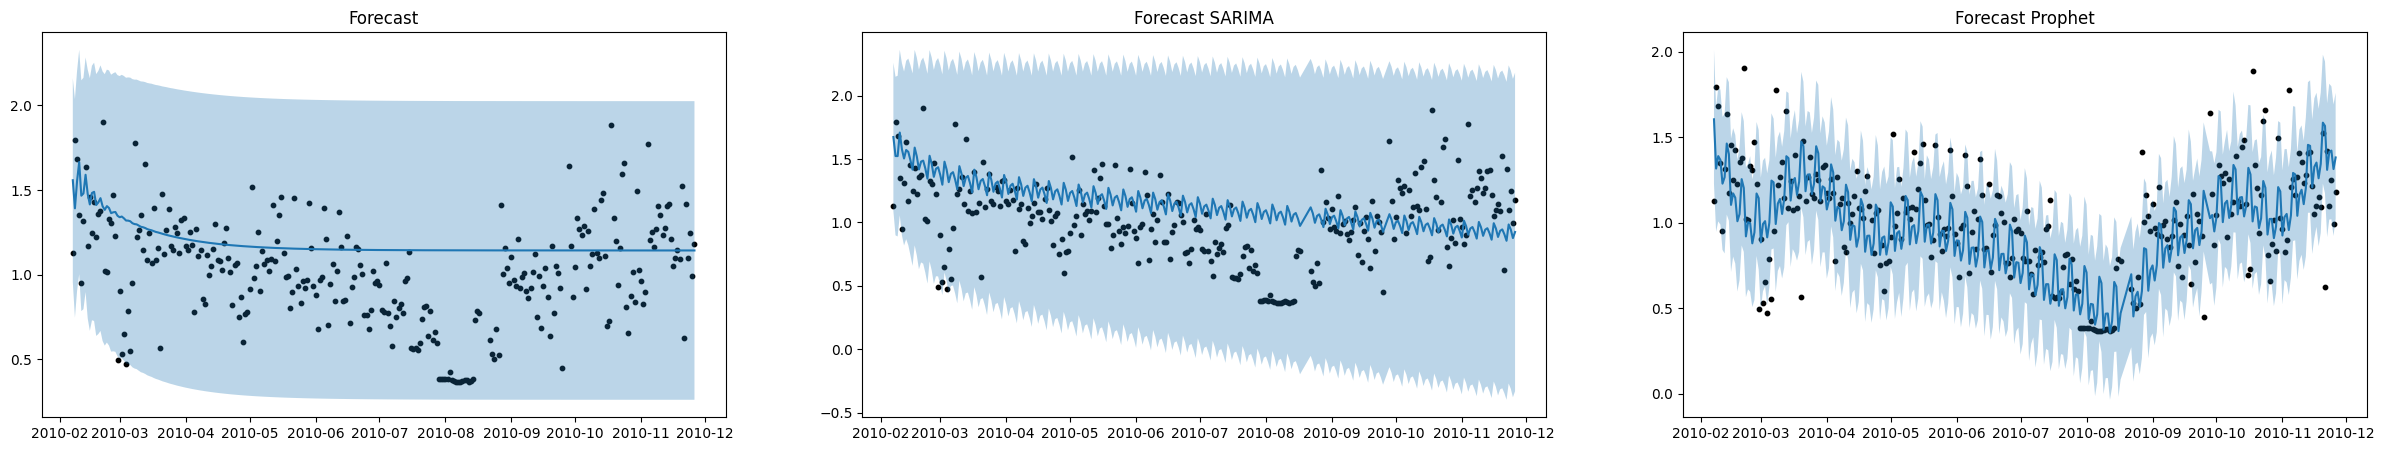

In [ ]:
# Confidence intervals
conf_arima = forecast_arima.conf_int()
conf_sarima = forecast_sarima.conf_int()

# Plot the visual comparison

plt.figure(figsize=(30,5))

# ARIMA
plt.subplot(1, 3, 1)
plt.plot(test.index, pred_arima)
plt.scatter(test.index ,y_true, color='black', s=10)
#plt.fill_between(test.index, y1 = conf_arima.iloc[:, 0], y2= conf_arima.iloc[:, 1], alpha=0.3)
plt.fill_between(test.index, y1 = conf_arima['lower Global_active_power'], y2= conf_arima['upper Global_active_power'], alpha=0.3)
plt.title("Forecast")

# SARIMA
plt.subplot(1, 3, 2)
plt.plot(test.index, pred_sarima)
plt.scatter(test.index ,y_true, color='black', s=10)
plt.fill_between(test.index, y1 = conf_sarima['lower Global_active_power'], y2= conf_sarima['upper Global_active_power'], alpha=0.3)
plt.title("Forecast SARIMA")

# Prophet
plt.subplot(1, 3, 3)
plt.plot(test.index, forecast_prophet_series)
plt.scatter(test.index ,y_true, color='black', s=10)
plt.fill_between(test.index, y1 = forecast_prophet['yhat_lower'], y2= forecast_prophet['yhat_upper'], alpha=0.3)
plt.title("Forecast Prophet")

plt.show()

**Understanding the result:**

*   All models estimate the overall trend well. However, Prophet is significantly better at capturing short-term trend variations, while ARIMA and SARIMA are less responsive to these changes.

*   Most observations fall within the uncertainty intervals, indicating that variability is not underestimated and the predictions are generally plausible. Prophet’s confidence intervals adapt more effectively to higher variability, providing more reliable predictions, although it slightly underestimates some of the most extreme consumption values. In contrast, ARIMA and SARIMA tend to produce wider intervals, resulting in higher uncertainty and less precision.

*   Prophet’s generally stronger performance suggests a clear benefit from including two seasonality levels (yearly and weekly) in the model.

**Residual Comparison Assessment**

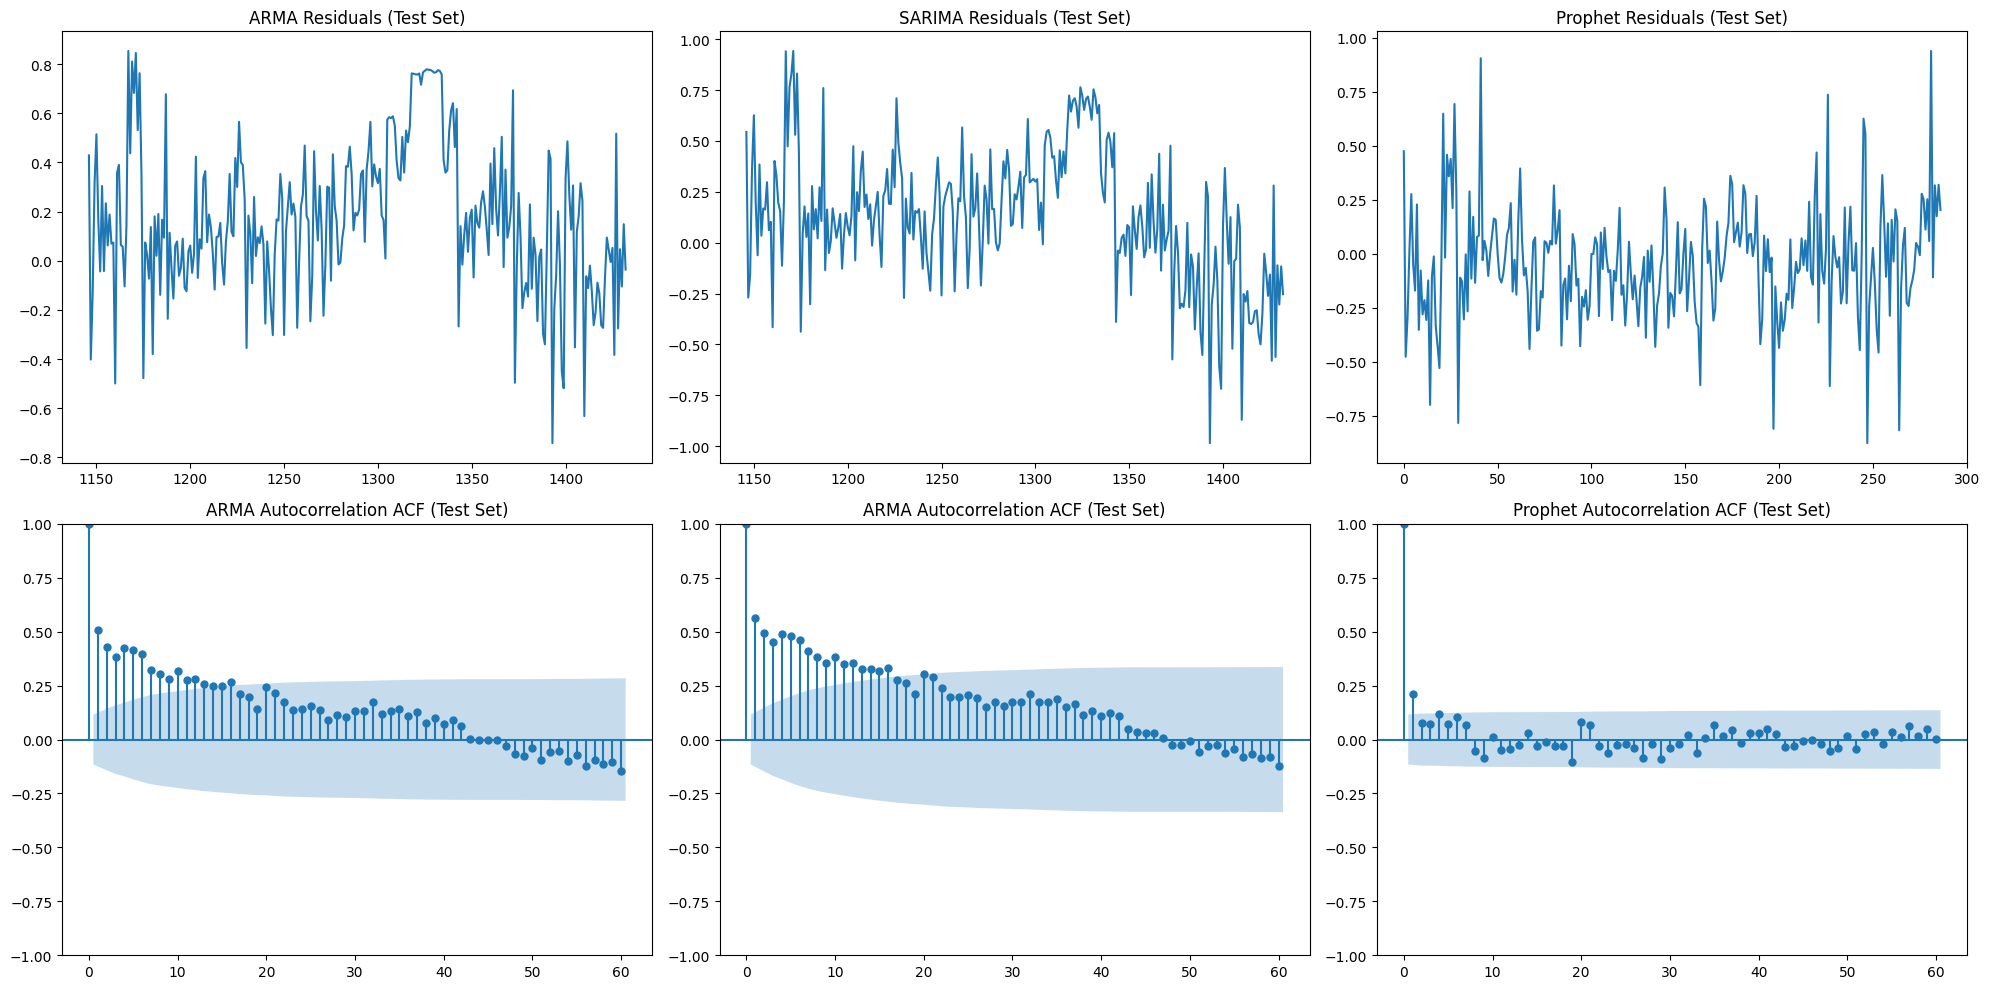

In [ ]:
# Residuals
res_arima = pred_arima - y_true
res_sarima = pred_sarima - y_true
res_prophet = forecast_prophet_series - y_true

#Plot

plt.figure(figsize=(20,10))

# ARIMA residuals
plt.subplot(2, 3, 1)
plt.plot(res_arima)
plt.title("ARMA Residuals (Test)")

# ARMA residuals ACF
ax2 = plt.subplot(2, 3, 4)
plot_acf(res_arima, lags=60, ax=ax2, title="ARMA Autocorrelation ACF (Test)")

# SARIMA residuals
plt.subplot(2, 3, 2)
plt.plot(res_sarima)
plt.title("SARIMA Residuals (Test)")

# SARIMA residuals ACF
ax4 = plt.subplot(2, 3, 5)
plot_acf(res_sarima, lags=60, ax=ax4, title="ARMA Autocorrelation ACF (Test)")

# Prophet residuals
plt.subplot(2, 3, 3)
plt.plot(res_prophet)
plt.title("Prophet Residuals (Test)")

# Prophet residuals ACF
ax6 = plt.subplot(2, 3, 6)
plot_acf(res_prophet, lags=60, ax=ax6, title="Prophet Autocorrelation ACF (Test)")

plt.tight_layout()
plt.show()

**Understanding the result:**


*   Residuals in the ARMA and SARIMA models are not centered around 0 and exhibit clear trends and patterns, upward at the beginning and downward toward the end. This indicates underfitting, as the models fail to fully capture the underlying data structure. The ACF shows a slow decay with several spikes outside the confidence region, confirming that trend and/or seasonality components are not adequately modeled.

*   Prophet’s residuals are much better centered around 0, with less pronounced patterns. Most autocorrelation spikes are statistically non-significant, indicating that trend and seasonality are modeled more effectively.

In summary, the Prophet model is by far the best choice for forecasting household consumption, as supported by error metrics and diagnostic results.